In [1]:
pip install yfinance --upgrade --no-cache-dir

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import yfinance as yf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import sys
import scipy.stats as stats
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.optimize import minimize

In [3]:
def loaddata(tickerlist, period='5y'):
    data = yf.download(  # or pdr.get_data_yahoo(...
            # tickers list or string as well
            tickers = tickerlist,

            # use "period" instead of start/end
            # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
            # (optional, default is '1mo')
            period = period,

            # fetch data by interval (including intraday if period < 60 days)
            # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
            # (optional, default is '1d')
            interval = "1d",

            # Whether to ignore timezone when aligning ticker data from 
            # different timezones. Default is False.
            ignore_tz = False, # !!

            # group by ticker (to access via data['SPY'])
            # (optional, default is 'column')
            group_by = 'ticker',

            # adjust all OHLC automatically
            # (optional, default is False)
            auto_adjust = True,  

            # attempt repair of missing data or currency mixups e.g. $/cents
            repair = False,

            # download pre/post regular market hours data
            # (optional, default is False)
            prepost = True,

            # use threads for mass downloading? (True/False/Integer)
            # (optional, default is True)
            threads = True,

            # proxy URL scheme use use when downloading?
            # (optional, default is None)
            proxy = None
        )
    collist = []
    
    for i in data.columns:
        if i[1] == 'Close': #there were no adj close for most tickers
            collist.append(i)
    data = data[collist]
    
    tmp = []
    for i in data.columns:
        tmp.append(i[0])
    data.columns = tmp
    
    return data

In [4]:
def CleanData(data): #for cleaning data of 1 pair
    # 1) drop weekend
    for i in range(data.shape[0]):
        if pd.isna(data.iloc[i,0]) and pd.isna(data.iloc[i,1]):
            data = data.drop(data.index[i],axis=0)
    # 2) cal logreturn
        cleaned_data = 100*np.log(data/data.shift(1))
    # 3) dropna
        cleaned_data = cleaned_data.dropna(axis=0)
    return cleaned_data

In [5]:
pair = '^GSPC ^RUA'
data = loaddata(pair)
print(data)

[*********************100%***********************]  2 of 2 completed
                                  ^RUA        ^GSPC
Date                                               
2018-02-28 00:00:00-05:00  1600.150024  2713.830078
2018-03-01 00:00:00-05:00  1581.170044  2677.669922
2018-03-02 00:00:00-05:00  1591.380005  2691.250000
2018-03-05 00:00:00-05:00  1608.609985  2720.939941
2018-03-06 00:00:00-05:00  1614.569946  2728.120117
...                                ...          ...
2023-02-22 00:00:00-05:00  2320.189941  3991.050049
2023-02-23 00:00:00-05:00  2332.050049  4012.320068
2023-02-24 00:00:00-05:00  2307.530029  3970.040039
2023-02-27 00:00:00-05:00  2314.389893  3982.239990
2023-02-28 00:00:00-05:00  2314.426025  3984.340088

[1259 rows x 2 columns]


In [6]:
clean_data = CleanData(data)
clean_data

,^RUA,^GSPC
Date,,
2018-03-01 00:00:00-05:00,-1.193228,-1.341397
2018-03-02 00:00:00-05:00,0.643646,0.505879
2018-03-05 00:00:00-05:00,1.076888,1.097162
2018-03-06 00:00:00-05:00,0.369819,0.263538
2018-03-07 00:00:00-05:00,0.047061,-0.048399
...,...,...
2023-02-22 00:00:00-05:00,-0.061190,-0.157480
2023-02-23 00:00:00-05:00,0.509868,0.531528
2023-02-24 00:00:00-05:00,-1.057003,-1.059346


In [7]:
sp = np.array(clean_data['^GSPC'])
rus = np.array(clean_data['^RUA'])

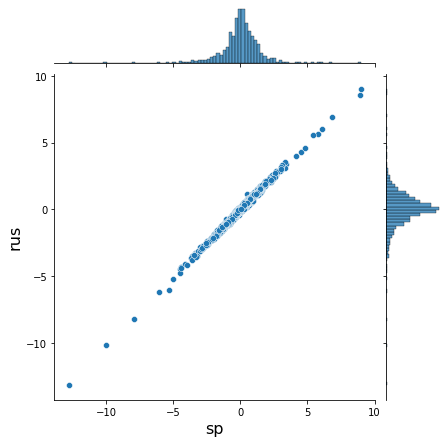

In [8]:
h = sns.jointplot(x=sp, y=rus, kind="scatter")
_ = h.set_axis_labels("sp", "rus", fontsize=16)

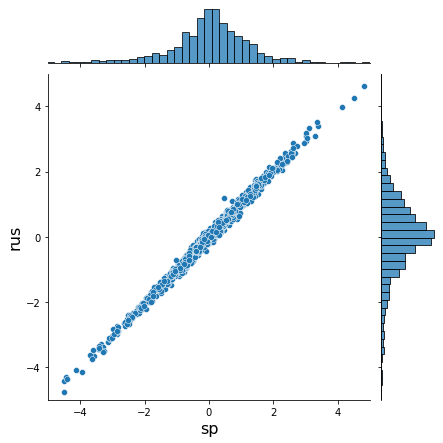

In [9]:
h = sns.jointplot(x=sp, y=rus, kind="scatter", xlim=[-5, 5], ylim=[-5, 5])
_ = h.set_axis_labels("sp", "rus", fontsize=16)

In [10]:
data = np.vstack((sp, rus))

# Transform the dataset to uniform margins
ecdf1 = ECDF(data[0])
ecdf2 = ECDF(data[1])
n = len(data[0])
pseudo_sample = np.array(
    [[n * l / (n + 1) for l in ecdf1(data[0])], [n * l / (n + 1) for l in ecdf2(data[1])]])

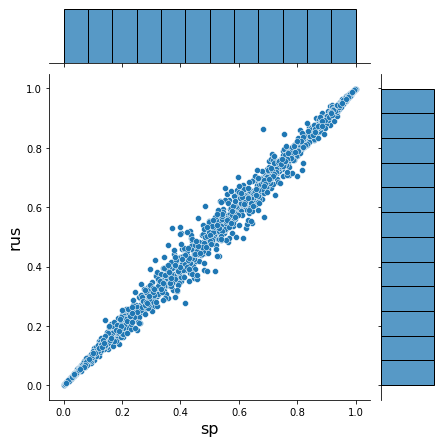

In [11]:
h = sns.jointplot(x=pseudo_sample[0], y=pseudo_sample[1], kind="scatter")
_ = h.set_axis_labels("sp", "rus", fontsize=16)

### Graphical Observation

From the graphical observation, Frank, Gaussian and Student-t copulas can be considered. 

### References

1. https://hudsonthames.org/copula-for-pairs-trading-introduction/
2. https://bochang.me/blog/posts/copula/
3. https://datasciencegenie.com/different-correlation-structures-in-copulas/

### Kendall's Tau 

In [12]:
import scipy.stats as stats
tau, p_value = stats.kendalltau(pseudo_sample[0], pseudo_sample[1])
print(tau)
print(p_value)

0.9406255212677231
0.0


### Maximum Likelihood

In [13]:
from statsmodels.distributions.copula.api import FrankCopula, GaussianCopula, StudentTCopula, ClaytonCopula, GumbelCopula
import scipy.integrate

from scipy.special  import comb
from scipy.special import erfinv
from scipy.special import gamma
from scipy.stats    import norm, t
from scipy.optimize import root
from scipy.optimize import newton
from scipy.optimize import minimize

import numpy.random as npr
import scipy.stats as scs

from distutils.log import error
from statsmodels.distributions.empirical_distribution import ECDF

import warnings

In [14]:
def gaussian_pdf(u, v, rho):
    
    a = np.sqrt(2) * erfinv(2 * u - 1)
    b = np.sqrt(2) * erfinv(2 * v - 1)
    det_rho = 1 - rho**2
    
    return det_rho**-0.5 * np.exp(-((a**2 + b**2) * rho**2 -2 * a * b * rho) / (2 * det_rho))

def studentT_pdf(u, v, param):

    rho = param[0]
    nu = param[1]

    term1 = gamma((nu + 2) / 2) * gamma(nu / 2) 
    term2 = gamma((nu + 1) / 2) ** 2

    u_ = t.ppf(u, df=nu)
    v_ = t.ppf(v, df=nu)

    det_rho = 1-rho**2
    multid = (-2 * u_ * v_ * rho + (u_ ** 2) + (v_ ** 2) ) / det_rho
    term3 = (1 + multid / nu) ** ((nu + 2) / 2)

    prod1 = (1 + (u_ ** 2) / nu) ** ((nu + 1) / 2) 
    prod2 = (1 + (v_ ** 2) / nu) ** ((nu + 1) / 2)
    prod = prod1 * prod2

    return (1/np.sqrt(det_rho)) * (term1 * prod) / (term2 * term3)

In [15]:
def cmle(copula, data, opti_method='SLSQP'):
    
    # Transform the dataset to uniform margins
    ecdf1 = ECDF(data[0])
    ecdf2 = ECDF(data[1])
    
    n = len(data[0])
    
    pseudo_sample = np.array(
        [[n * l / (n + 1) for l in ecdf1(data[0])], [n * l / (n + 1) for l in ecdf2(data[1])]])
    
    # calculate the log likelihood
    def log_likelihood(parameter):
        if isinstance(copula, GaussianCopula):
            logl = -np.sum(np.log(gaussian_pdf(pseudo_sample[0], pseudo_sample[1], parameter)))
        elif isinstance(copula, StudentTCopula):
            logl = -np.sum(np.log(studentT_pdf(pseudo_sample[0], pseudo_sample[1], parameter)))
        else:
            logl = -np.sum(np.log(copula.pdf(pseudo_sample.T, parameter)))
        return logl
    
    # fitting

    if isinstance(copula, ClaytonCopula):
        initial_param = 0.5
        bounds_param = [(1e-6, None)]
    elif isinstance(copula, FrankCopula):
        initial_param = 2
        bounds_param = [(None, None)]
    elif isinstance(copula, GumbelCopula):
        initial_param = 1.5
        bounds_param = [(1, None)]
    elif isinstance(copula, GaussianCopula):
        initial_param = 0
        bounds_param = [(-1, 1)]
    elif isinstance(copula, StudentTCopula):
        initial_param = [0, 1]
        bounds_param = [(-1+1e-6, 1-1e-6), (1e-6, None)]
        opti_method = 'Nelder-Mead'
    else:
        print("only available with Clayton, Frank, Gumbel, Gaussian and StudentT")
    
    results = minimize(log_likelihood, initial_param, method=opti_method, bounds=bounds_param, options={})
    
    if results.success == True:
            return (results.x, -results.fun)      # return the fitted theta and the loglikelihood
    else:
        print("fitting failed")
        return None

In [17]:
def copula_selection(copulas_lst, data):
    
    results = {}
    
    for key in copulas_lst:
        
        if key == 'Gaussian':
            ecdf1 = ECDF(data[0])
            ecdf2 = ECDF(data[1])
            n = len(data[0])
            pseudo_sample = np.array(
                [[n * l / (n + 1) for l in ecdf1(data[0])], [n * l / (n + 1) for l in ecdf2(data[1])]])
            cor = np.corrcoef(pseudo_sample[0], pseudo_sample[1])
            copula = GaussianCopula(corr=cor)
            cor, like = cmle(copula, data)
            results[key] = (cor, like)
            
        elif key == 'StudentT':
            ecdf1 = ECDF(data[0])
            ecdf2 = ECDF(data[1])
            n = len(data[0])
            pseudo_sample = np.array(
                [[n * l / (n + 1) for l in ecdf1(data[0])], [n * l / (n + 1) for l in ecdf2(data[1])]])
            cor = np.corrcoef(pseudo_sample[0], pseudo_sample[1])
            copula = StudentTCopula(corr=cor, df=data.shape[1]-1)
            param, like = cmle(copula, data)
            results[key] = param, like
            
        elif key == 'Frank':
            copula = FrankCopula()
            the, like = cmle(copula, data)
            results[key] = the[0], like
        
        elif key == 'Clayton':
            copula = ClaytonCopula()
            the, like = cmle(copula, data)
            results[key] = the[0], like
            
        elif key == 'Gumbel':
            copula = GumbelCopula()
            the, like = cmle(copula, data)
            results[key] = the[0], like
            
        else:
            raise NotImplementedError
            
    results = results.items()
    final = dict(sorted(results, key=lambda ele:ele[1][1]))
    
    return final

In [18]:
copulas_lst = ['Gaussian', 'StudentT', 'Frank', 'Clayton', 'Gumbel']
final = copula_selection(copulas_lst, data)
final

/var/folders/60/75vh_thj2m57nynzg5tgw0300000gn/T/ipykernel_66703/1604078958.py:7: RuntimeWarning: divide by zero encountered in power
  return det_rho**-0.5 * np.exp(-((a**2 + b**2) * rho**2 -2 * a * b * rho) / (2 * det_rho))
/var/folders/60/75vh_thj2m57nynzg5tgw0300000gn/T/ipykernel_66703/1604078958.py:7: RuntimeWarning: divide by zero encountered in true_divide
  return det_rho**-0.5 * np.exp(-((a**2 + b**2) * rho**2 -2 * a * b * rho) / (2 * det_rho))
/var/folders/60/75vh_thj2m57nynzg5tgw0300000gn/T/ipykernel_66703/1604078958.py:7: RuntimeWarning: invalid value encountered in true_divide
  return det_rho**-0.5 * np.exp(-((a**2 + b**2) * rho**2 -2 * a * b * rho) / (2 * det_rho))
/var/folders/60/75vh_thj2m57nynzg5tgw0300000gn/T/ipykernel_66703/1604078958.py:7: RuntimeWarning: invalid value encountered in multiply
  return det_rho**-0.5 * np.exp(-((a**2 + b**2) * rho**2 -2 * a * b * rho) / (2 * det_rho))
/var/folders/60/75vh_thj2m57nynzg5tgw0300000gn/T/ipykernel_66703/2713152495.py:15: 

{'Frank': (18.730568454538492, 1912.4363225163079),
 'Clayton': (21.97530772615752, 2591.452573834671),
 'Gumbel': (16.575628346596403, 2839.1780769509805),
 'Gaussian': (array([0.99578335]), 2860.4758369560177),
 'StudentT': (array([9.99999e-01, 1.00000e-06]), 23330.070832964637)}

## Goodness of Fit

#### Empirical Copula 

In [19]:
def build_ecopula(pseudo_sample, interval=5):
    
    # selecting sample from every 5 samples, default interval is 5
    axis1 = np.sort(pseudo_sample[0, ::interval])
    axis2 = np.sort(pseudo_sample[1, ::interval])
    
    lists = [[] for _ in range(len(axis1))]

    for i in range(len(axis1)):
        for j in range(len(axis2)):
            point = (axis1[i], axis2[j])
            lists[i].append(point)
    lists = np.array(lists)
    
    samples = pseudo_sample[:, ::interval]
    
    c_lists = [[] for _ in range(len(lists))]

    for i in range(len(lists)):
        for j in range(len(lists)):
            count = 0
            point = lists[i][j]
            for sample in samples.T:
                if sample[0] <= point[0] and sample[1] <= point[1]:
                    count += 1
            c_lists[i].append(count/len(lists))

    e_copula = np.array(c_lists)
    
    return axis1, axis2, lists, e_copula

In [20]:
axis1, axis2, lists, e_copula = build_ecopula(pseudo_sample)

### GoF

In [21]:
def GoF(copula, e_copula, lists, axis1, axis2, final):
    
    results = []
    dis = 0
    
    if copula == 'Frank':
        copula = FrankCopula(theta=float(final['Frank'][0]))
                
    elif copula == 'Gaussian':
        cor = np.corrcoef(axis1, axis2)
        copula = GaussianCopula(corr=cor)
                
    elif copula == 'Clayton':
        copula = ClaytonCopula(theta=float(final['Clayton'][0]))
                
    elif copula == 'Gumbel':
        copula = GumbelCopula(theta=float(final['Gumbel'][0]))
        
    else:
        raise NotImplementedError
        
    for i in range(len(lists)):
        results.append(copula.cdf(lists[i]))
        
    for i in range(len(e_copula)):
        for j in range(len(e_copula[i])):
            e = e_copula[i][j]
            r = results[i][j]
            dis += (e-r)**2
                
    return dis

In [22]:
print(GoF('Frank', e_copula, lists, axis1, axis2, final))
print(GoF('Gaussian', e_copula, lists, axis1, axis2, final))
print(GoF('Clayton', e_copula, lists, axis1, axis2, final))
print(GoF('Gumbel', e_copula, lists, axis1, axis2, final))

21.382790591589036
13.121663019054562
14.467722761639472
13.463330061115359
